In [499]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers

In [500]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [501]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [502]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [503]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [527]:
# train: 140, val: 500, test: 1000
train_data, val_data, test_data = [], [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    train_num = int(np.round(len(group_data.index) / len(papers.index) * 1000))
    val_num = int(np.round(len(group_data.index) / len(papers.index) * 500))
    test_num = int(np.round(len(group_data.index) / len(papers.index) * 1000))
    total = train_num + val_num + test_num
    random_selection = random.sample(range(len(group_data.index)), total) 
    random_selection_train = [i in random_selection[:train_num] for i in range(len(group_data.index))]
    random_selection_val = [i in random_selection[train_num:train_num + val_num] for i in range(len(group_data.index))]
    random_selection_test = [i in random_selection[train_num + val_num:] for i in range(len(group_data.index))]
    #random_selection = np.random.rand(len(group_data.index)) <= 0.1
    train_data.append(group_data[random_selection_train])
    val_data.append(group_data[random_selection_val])
    test_data.append(group_data[random_selection_test])

train_data = pd.concat(train_data).sample(frac=1)
val_data = pd.concat(val_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Val data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (999, 1435)
Val data shape: (500, 1435)
Test data shape: (999, 1435)


In [528]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_val = val_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_val = val_data["subject"]
y_test = test_data["subject"]

In [529]:
hidden_units = [32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = train_data.shape[0] # update on entire training dataset

In [530]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

new_instances = generate_random_instances(num_classes)

In [531]:
def run_experiment(model, x_train, y_train, x_val, y_val):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
        #metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=30, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        #validation_split=0.15,
        validation_data=(x_val, y_val),
        #callbacks=[early_stopping],
    )

    return history

In [532]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [533]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [534]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        #self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = layers.Dense(hidden_units[0], activation=tf.nn.relu)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages. self-loop
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        #neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_repesentations)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [545]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="add",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            [100],
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="convoluted_layer",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            [200],
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="convoluted_layer",
        )
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits", activation=tf.nn.softmax)

    def call(self, input_node_indices):
        # Apply the first graph conv layer.
        x = self.conv1((self.node_features, self.edges, self.edge_weights))
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x2, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)

In [550]:
gcn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gcn_model",
)

print("GCN output shape:", gcn_model([1, 10, 100]))

gcn_model.summary()

GCN output shape: tf.Tensor(
[[0.15136588 0.1311257  0.15500298 0.13863246 0.14122391 0.13143599
  0.15121317]
 [0.14743939 0.14874634 0.13747722 0.14421804 0.13402586 0.13737099
  0.15072219]
 [0.14477801 0.1574844  0.14907838 0.12726489 0.1405256  0.13529316
  0.14557558]], shape=(3, 7), dtype=float32)
Model: "gcn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convoluted_layer (GraphConvL multiple                  143400    
_________________________________________________________________
convoluted_layer (GraphConvL multiple                  20200     
_________________________________________________________________
logits (Dense)               multiple                  1407      
Total params: 165,007
Trainable params: 165,007
Non-trainable params: 0
_________________________________________________________________


In [551]:
x_train = train_data.paper_id.to_numpy()
x_val = val_data.paper_id.to_numpy()
history = run_experiment(gcn_model, x_train, keras.utils.to_categorical(y_train, 7), x_val, keras.utils.to_categorical(y_val, 7))

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 1.9452 - acc: 0.1562 - val_loss: 1.9068 - val_acc: 0.3020
Epoch 2/50
1/1 [==============================] - 0s 315ms/step - loss: 1.9034 - acc: 0.3023 - val_loss: 1.8807 - val_acc: 0.3420
Epoch 3/50
1/1 [==============================] - 0s 310ms/step - loss: 1.8744 - acc: 0.3453 - val_loss: 1.8526 - val_acc: 0.4900
Epoch 4/50
1/1 [==============================] - 0s 312ms/step - loss: 1.8422 - acc: 0.5255 - val_loss: 1.8253 - val_acc: 0.6260
Epoch 5/50
1/1 [==============================] - 0s 318ms/step - loss: 1.8097 - acc: 0.6667 - val_loss: 1.7995 - val_acc: 0.7180
Epoch 6/50
1/1 [==============================] - 0s 321ms/step - loss: 1.7781 - acc: 0.7798 - val_loss: 1.7738 - val_acc: 0.7780
Epoch 7/50
1/1 [==============================] - 0s 333ms/step - loss: 1.7473 - acc: 0.8468 - val_loss: 1.7495 - val_acc: 0.7880
Epoch 8/50
1/1 [==============================] - 0s 331ms/step - loss: 1.7181 - acc: 0.8849 

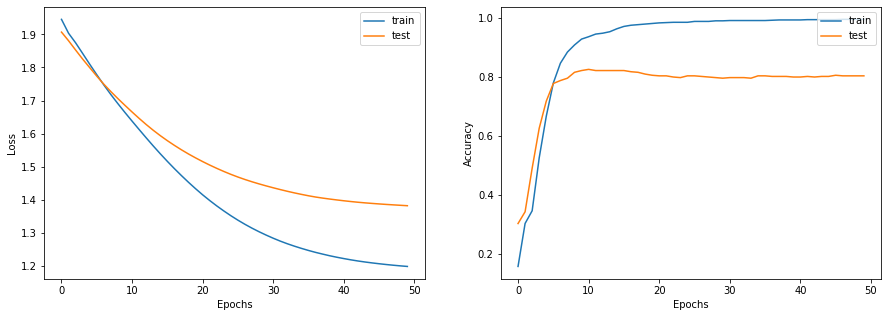

In [552]:
display_learning_curves(history)

In [553]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gcn_model.evaluate(x=x_test, y=keras.utils.to_categorical(y_test, 7), verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 82.78%


In [523]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [524]:
print("Original node_features shape:", gcn_model.node_features.shape)
print("Original edges shape:", gcn_model.edges.shape)
gcn_model.node_features = new_node_features
gcn_model.edges = new_edges
gcn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gcn_model.node_features.shape)
print("New edges shape:", gcn_model.edges.shape)

logits = gcn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2715, 1433)
Original edges shape: (2, 5478)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
Instance 1:
- Case_Based: 29.71%
- Genetic_Algorithms: 11.68%
- Neural_Networks: 11.89%
- Probabilistic_Methods: 11.66%
- Reinforcement_Learning: 11.66%
- Rule_Learning: 11.67%
- Theory: 11.73%
Instance 2:
- Case_Based: 11.61%
- Genetic_Algorithms: 30.38%
- Neural_Networks: 11.63%
- Probabilistic_Methods: 11.59%
- Reinforcement_Learning: 11.59%
- Rule_Learning: 11.59%
- Theory: 11.6%
Instance 3:
- Case_Based: 11.55%
- Genetic_Algorithms: 11.61%
- Neural_Networks: 30.56%
- Probabilistic_Methods: 11.64%
- Reinforcement_Learning: 11.55%
- Rule_Learning: 11.54%
- Theory: 11.55%
Instance 4:
- Case_Based: 11.59%
- Genetic_Algorithms: 11.58%
- Neural_Networks: 11.65%
- Probabilistic_Methods: 30.45%
- Reinforcement_Learning: 11.56%
- Rule_Learning: 11.56%
- Theory: 11.6%
Instance 5:
- Case_Based: 12.38%
- Genetic_Algorithms: 13.78%
- Neural_Networks: 13.63